# Pelican Data Extract and 3D Velocity Calculations
*Eric G. Suchanek, Ph.D. 3/15/19*

This code performs a Gaia rectangular search from 20h50m18s, 44d13m30s to 20h51m22s 44d25m0s and extracts:
* ra, dec, pmra, pmdec, pmra_error, pmdec_error, parallax, parallax_error, g_mean_mag

The Radial_velocities were generally unavailable. No variability data was available either for this query. As a result I changed the query to not pull these fields. 3d velocities were calculated per the formulae discussed in: http://www.astronexus.com/a-a/motions-long-term. These values were then written out to a csv file containing the query results.

In [1]:
#
# Setup the libraries. 

import astropy.units as u
import astropy.coordinates as coord

from astropy.coordinates import Latitude, Longitude, Angle, SkyCoord
#from astropy.units import Quantity

from astroquery.gaia import Gaia
from astropy.visualization import astropy_mpl_style, quantity_support
#import aplpy
from astropy.io import ascii
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

import progressbar

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

from pandas import read_csv
%matplotlib inline

# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

import egs
from egs import compute_pm_angles


Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


Returned: 912 stars


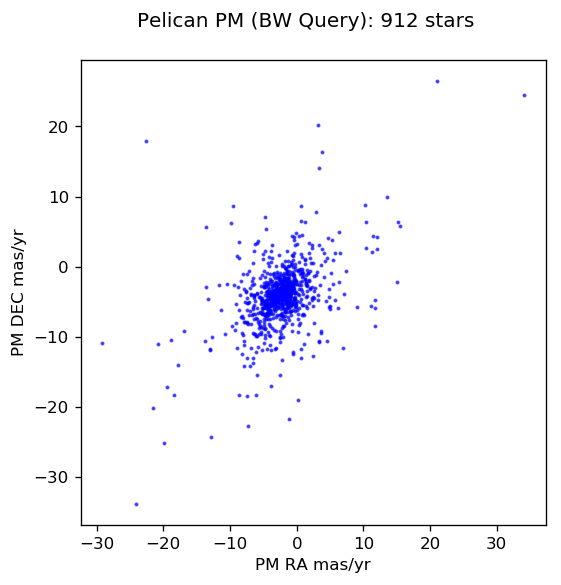

In [2]:
# Bruce's search parameters - area 1

_ra1 = "20h50m18s" # 300.8383
_dec1 = "44d13m30s" # 44.225

_ra2 = "20h51m22s" # 300.8561
_dec2 = "44d25m0s" # 44.41667

# this will do the math to calculate the angular
# width of the query box
ra1 = Longitude(_ra1,unit=u.hourangle)
ra2 = Longitude(_ra2, unit=u.hourangle)

dec1 = Latitude(_dec1,unit=u.degree)
dec2 = Latitude(_dec2,unit=u.degree)

ra_diff = ra2 - ra1
dec_diff = dec2 - dec1 
ra_center = ra1 + ra_diff / 2
dec_center = dec1 + dec_diff / 2

# raw string from Gaia
# hard coded for area 1, direct from the Gaia 
q_str = "SELECT TOP 999999 gaia_source.source_id,gaia_source.ra,gaia_source.ra_error,\
gaia_source.dec,gaia_source.dec_error,gaia_source.parallax,gaia_source.parallax_error,\
gaia_source.pmra,gaia_source.pmra_error,gaia_source.pmdec,gaia_source.pmdec_error,\
gaia_source.phot_g_mean_mag,gaia_source.radial_velocity,gaia_source.radial_velocity_error,\
gaia_source.phot_variable_flag FROM gaiadr2.gaia_source  \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),\
BOX('ICRS',312.7083333333333,44.32083333333333,0.2666666666666515,0.19166666666666288))=1  "


# only pull non-null parallax, pmra, and pmdec
sel_str_box2 = "SELECT TOP 2000 gaia_source.source_id,gaia_source.ra,gaia_source.ra_error,\
gaia_source.dec,gaia_source.dec_error,gaia_source.parallax,gaia_source.parallax_error,\
gaia_source.pmra,gaia_source.pmra_error,gaia_source.pmdec,gaia_source.pmdec_error,\
gaia_source.phot_g_mean_mag FROM gaiadr2.gaia_source  \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),BOX('ICRS',{},{},{},{}))=1 \
AND gaia_source.parallax IS NOT NULL \
AND gaia_source.pmra IS NOT NULL \
AND gaia_source.pmdec IS NOT NULL ;"

sel_str_box = "SELECT TOP 2000 * FROM gaiadr2.gaia_source  \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),BOX('ICRS',{},{},{},{}))=1 \
AND gaia_source.parallax IS NOT NULL \
AND gaia_source.pmra IS NOT NULL \
AND gaia_source.pmdec IS NOT NULL;"


sel_str_box_id_restricted = "SELECT TOP 2000 * FROM gaiadr2.gaia_source  \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),BOX('ICRS',{},{},{},{}))=1 \
AND gaia_source.parallax IS NOT NULL \
AND gaia_source.pmra IS NOT NULL \
AND gaia_source.pmdec IS NOT NULL \
AND gaia_source.solution_id = {};"

sel_str_box_id_all = "SELECT TOP 2000 * FROM gaiadr2.gaia_source  \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),BOX('ICRS',{},{},{},{}))=1 \
AND gaia_source.solution_id = {};"


project_name = "./area1/egsPM_"

data_filename = project_name + _ra1 + "_" + _dec1 + "_" + _ra2 + "_" + _dec2 + "_" + "_deg.csv"
vel_filename =  project_name + _ra1 + "_" + _dec1 + "_" + _ra2 + "_" + _dec2 + "_deg_vel_out.csv"

q = str.format(sel_str_box,312.708333,44.3208333,0.2666667,0.1966667)
job = Gaia.launch_job_async(query=q, dump_to_file=True, 
                            output_file=data_filename, output_format='csv')
stars_pm = job.get_results()
star_count = len(stars_pm)  # global variable

# all in mas, convert to arcsecs
angles = compute_pm_angles(stars_pm)
pmra = stars_pm['pmra']
pmdec = stars_pm['pmdec']

ra = stars_pm['ra']
dec = stars_pm['dec']

# convert to long and lat to get the units right
ra = Longitude(ra,unit=u.deg)
dec = Latitude(dec,unit=u.deg)

print(str.format("Returned: {} stars", star_count))

# scatter plot
fig, ax = plt.subplots(figsize=(5,5),dpi=120)

ax.scatter(stars_pm['pmra'], stars_pm['pmdec'], color='b', alpha=0.6, s=2)

fig.subplots_adjust(top=0.90)
fig.suptitle('Pelican PM (BW Query): ' + str(star_count) + ' stars', 
             fontsize=12)
# ax.set_title('axes title')
ax.set_xlabel('PM RA mas/yr')
ax.set_ylabel('PM DEC mas/yr')

plt.show()

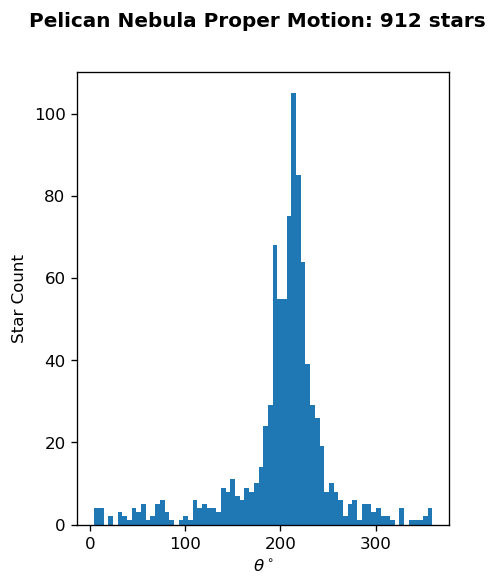

In [3]:
fig, ax = plt.subplots(figsize=(4,5),dpi=120)
fig.suptitle('Pelican Nebula Proper Motion: '+ str(star_count)+ ' stars', 
              fontsize=12, fontweight='bold')

ax.set_xlabel(r"$\theta^\circ$")
ax.set_ylabel('Star Count')
n_bins = 72
x = []

x = compute_pm_angles(stars_pm)
ax.hist(x, bins=n_bins)

plt.show()

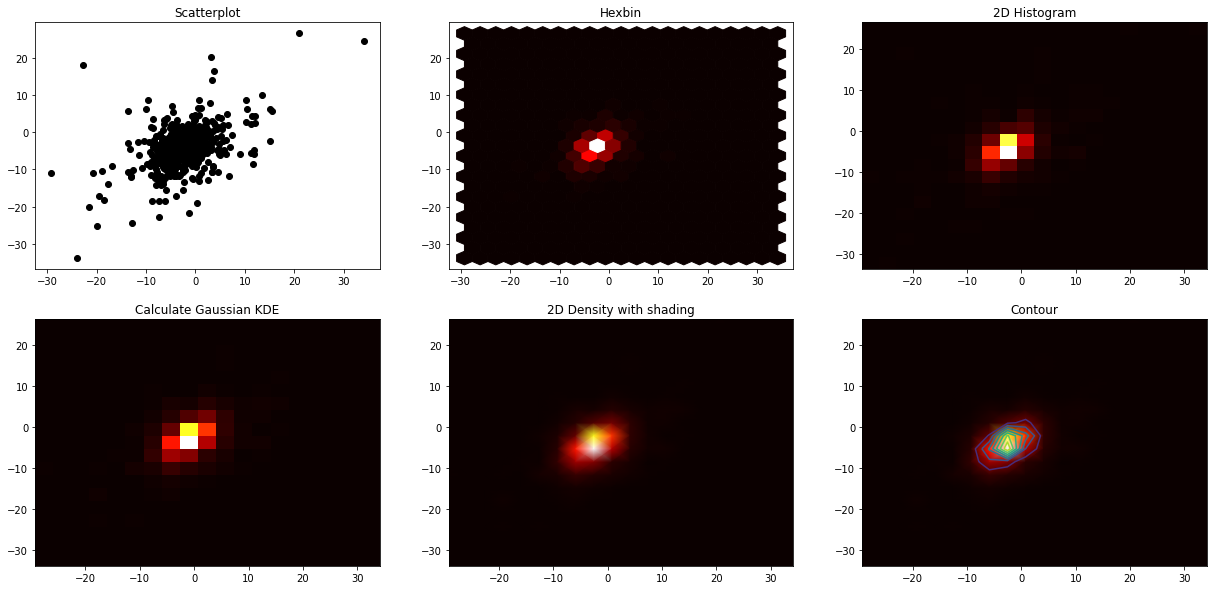

In [4]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde
 
# Create data: 200 points
#data = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 3]], 200)

pmra = np.asarray(pmra)
pmdec = np.asarray(pmdec)

data = np.column_stack((pmra,pmdec))
#print(pmra)
#print(data)
x, y = data.T
 
# Create a figure with 6 plot areas
fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(21, 10))
 
# Everything sarts with a Scatterplot
axes[0][0].set_title('Scatterplot')
axes[0][0].plot(x, y, 'ko')
# As you can see there is a lot of overplottin here!
 
# Thus we can cut the plotting window in several hexbins
nbins = 20
axes[0][1].set_title('Hexbin')
axes[0][1].hexbin(x, y, gridsize=nbins, cmap=plt.cm.hot)
 
# 2D Histogram
axes[0][2].set_title('2D Histogram')
axes[0][2].hist2d(x, y, bins=nbins, cmap=plt.cm.hot)
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = kde.gaussian_kde(data.T)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# plot a density
axes[1][0].set_title('Calculate Gaussian KDE')
axes[1][0].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.hot)
 
# add shading
axes[1][1].set_title('2D Density with shading')
axes[1][1].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.hot)
 
# contour
axes[1][2].set_title('Contour')
axes[1][2].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.hot)
axes[1][2].contour(xi, yi, zi.reshape(xi.shape) )
plt.show()



In [5]:
import numpy as np
from scipy import stats
from mayavi import mlab
import multiprocessing
from scipy.stats import norm

def calc_kde(data):
    return kde(data.T)

# mu, sigma = 220, 30 

x = np.asarray(ra)
y = np.asarray(dec)
z = np.asarray(angles)

(mu, sigma ) = norm.fit(z)

xyz = np.vstack([x,y,z])
kde = stats.gaussian_kde(xyz)

figure = mlab.figure('DensityPlot')
pts = mlab.points3d(x, y, z, density, scale_mode='none', scale_factor=0.07)
mlab.axes()
mlab.show()

NameError: name 'density' is not defined

In [6]:
# Evaluate kde on a grid
xmin, ymin, zmin = x.min(), y.min(), z.min()
xmax, ymax, zmax = x.max(), y.max(), z.max()
xi, yi, zi = np.mgrid[xmin:xmax:30j, ymin:ymax:30j, zmin:zmax:30j]
coords = np.vstack([item.ravel() for item in [xi, yi, zi]]) 

# Multiprocessing
cores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=cores)
results = pool.map(calc_kde, np.array_split(coords.T, 2))
density = np.concatenate(results).reshape(xi.shape)

# Plot scatter with mayavi
figure = mlab.figure('DensityPlot')

grid = mlab.pipeline.scalar_field(xi, yi, zi, density)
min = density.min()
max=density.max()
mlab.pipeline.volume(grid, vmin=min, vmax=min + .5*(max-min))

mlab.axes()
mlab.show()